# **Virtual Distributed Quantum Computing (VDQC)**: Emulating Distributed Circuits 

Limitations in single Quantum Proccessing Units (QPU's), namely, their low qubit counts, have generated plenty of interest in modular architectures, which aim to string together many chips in a bid to reach utility scale qubit counts. For example, quantum algorithms with a theoretically proven advantage over classical ones such as Shor's and Grovers require currently intractable single-chip qubit counts to truly reach their potential. 

However, contemporary methods of connecting QPU's are still in their infancy. One technique, using photons and beamsplitter operations suffer terribly from noise and can be 300x more costly than intra-chip operations. For this reason, a versatile simulation method must be developed.

This notebook walks through a basic VDQC experiment including; generating a virtual backend, developing a logical-to-backend qubit map, transpiling a partitioned circuit given by DisQCO and implemeneting communication qubit specific noise models.


In [2]:
import qiskit
import disqco
qiskit.__version__

'1.2.4'

#### **Designing a Virtual Backend:**

The starting place of a virtual DQC experiment is the creation of a custom fake backend. The aim is to generate a qubit coupling map that restricts communication between virtual QPU's to specific channels, where our teleportation procedures will run, emulating the bottleneck encountered in real developments.

We will make use of Qiskit's ```GenericBackendV2``` and ```CouplingMap``` classes to enable us use of Qiskit based simulators.

But first, we'll need to define some utility functions.

In [3]:
### Helper function that constructs populated 2D nearest-neighbour graph using networkx

def build_graph(size):

    """
    Args:
        size (int): Size parameter for square grid graph

    Returns:
        graph (nx.Graph): networkx graph object
        edges (list): list of bidirectional edges, required for 2 way qubit communciation in Qiskit's CouplingMap
    """

    import networkx as nx

    graph = nx.grid_graph([size, size])

    coord_to_int = {coord: i for i, coord in enumerate(graph.nodes())}

    edges = []
    for u, v in graph.edges():
        u_int = coord_to_int[u]
        v_int = coord_to_int[v]
        edges.append((u_int, v_int)) # forward edge
        edges.append((v_int, u_int)) # backward edge

    return graph, edges


In [4]:
### Helper function to extract circuit qubit indicies of communcation pairs, and between which QPU's they connect.
### Makes later logical to physics qubit mappings easier to construct.

def extract_communication_pairs(circuit):
    """
    Extracts communication pairs from a disqco partitioned circuit.

    Returns:
        list of lists: [
            [(logical_qubit_1, logical_qubit_2), (qpu_of_qubit_1, qpu_of_qubit_2)]
        ]
    """
    communication_pairs = []

    for instr, qargs, _ in circuit.data:
        if instr.name.lower() == 'epr':  # only process EPR gates
            # Get logical qubit indices in the circuit
            logical_indices = [circuit.find_bit(q).index for q in qargs]

            # Extract QPU indices from the qubit names
            qpu_indices = []
            for q in qargs:
                name = q._register.name
                if name.startswith('C'):
                    # Parse name like "C1_1" -> QPU index = 1
                    qpu_id = int(name.split('_')[0][1:])
                else:
                    # If it's not a communication qubit, assign None or -1
                    qpu_id = None
                qpu_indices.append(qpu_id)

            # Combine into desired format
            communication_pairs.append([(logical_indices[0], logical_indices[1]),
                                        (qpu_indices[0], qpu_indices[1])])

    return communication_pairs



Using these, we will be able to construct a graph compatible with Qiskit's CouplingMap class and quickly extract the teleportation requirements given a DisQCO partitioned circuit.

The toy backend used in this tutorial is a simple grid lattice structure, whereby data qubits are arranged in 2x2 grids and seperated from one another with a minimum 2 qubit gap, allowing space for communication qubit channels.

Specifically, we will build a virtual backend encoding 2 QPU's each with 4 qubits on.

In [5]:
from disqco.graphs.quantum_network import QuantumNetwork, all_to_all

qpu_sizes = {0 : 4, 1 : 4}

num_qpus = len(qpu_sizes)

coupling = all_to_all(num_qpus)

network = QuantumNetwork(qpu_sizes, qpu_connectivity=coupling)

Building the coupling map, we will use the ```build_graph``` function given earlier, and then filter its edges according to the previously given backend architecture. It is now appropriate to define the circuit we wish to partition. Distributing a GHZ-preperation circuit across 2 QPU's of size 4 each follows;

In [6]:
circuit_size = 8

from qiskit import QuantumCircuit, transpile

### Circuit Creation
qc = QuantumCircuit(circuit_size)
qc.h(0)
for k in range(1, circuit_size):
    qc.cx(0,k)
qc.measure_all()

### Transpilation to basis gates accepted by disqco
qc = transpile(qc, basis_gates=['u', 'cp'])


In [ ]:
from disqco.graphs.QC_hypergraph import QuantumCircuitHyperGraph

qc_hypergraph = QuantumCircuitHyperGraph(qc, group_gates=True)

from disqco.parti.FM.FM_methods import set_initial_partition_assignment

partition_assignment = set_initial_partition_assignment(qc_hypergraph, network)

print(f'Partition assignment: \n {partition_assignment}')

from disqco.circuit_extraction.circuit_extractor import PartitionedCircuitExtractor

circuit_extractor = PartitionedCircuitExtractor(qc_hypergraph, network, partition_assignment=partition_assignment)

partitioned_circuit = circuit_extractor.extract_partitioned_circuit()

print(f'Number of e-bits requested: {partitioned_circuit.count_ops()["EPR"]}')

circuit_registers = partitioned_circuit._qubit_indices

partitioned_circuit.draw(output='mpl', fold=50)



For such a trivial case, it is easy to manually assign data and communication qubits. We do this through a logical to physical qubit mapping, using the indicies provided by the disqco partitioned circuit and the indicies of empty nodes given by the networkX graph. The communicaton qubits must be carefully placed, to ensure they connect the two virtual QPU's using Manhatten geometry. <sup>[1]</sup>

In [ ]:
### Building backend connectivity.

### QPU structure will be 2 x 2 grid of qubits.

graph, edges = build_graph(6)

lqs = partitioned_circuit.qubits # logical qubits taken from the partitioned circuit

qpu_A = [0,1,6,7]       # The contents of the QPU lists are the graph node indicies for which the QPU is made up of.
qpu_B = [4,5,10,11]

qpu_A_mapping = {lqs[i] : qpu_A[i] for i in range(len(qpu_A))}   # logical-to-physical qubit mapping for QPU A
qpu_B_mapping = {lqs[i+5] : qpu_B[i] for i in range(len(qpu_B))}   # logical-to-physical qubit mapping for QPU B

### Extracting the communication qubits.

pairs = extract_communication_pairs(partitioned_circuit)  # list of communication pairs

comm_1 = pairs[0][0][0]   # logical qubit indices for qubits involved in the first communication pair
comm_2 = pairs[0][0][1]


communication_mapping = {lqs[comm_1]: 2, lqs[comm_2]: 3}   # logical-to-physical qubit mapping for communication qubits (ebits)

### Creating the qubit to qpu mapping.

qubit_to_qpu_mapping = qpu_A_mapping | communication_mapping | qpu_B_mapping


Now, filtering out edges that do not involve any qubits or break the connectivity restraints.

In [11]:
### Filtering graph edges to become a valid CouplingMap for VDQC.

active_nodes = qubit_to_qpu_mapping.values()

modified_edges = [(x, y) for (x, y) in edges if x in active_nodes and y in active_nodes]


We can then plot our topology.

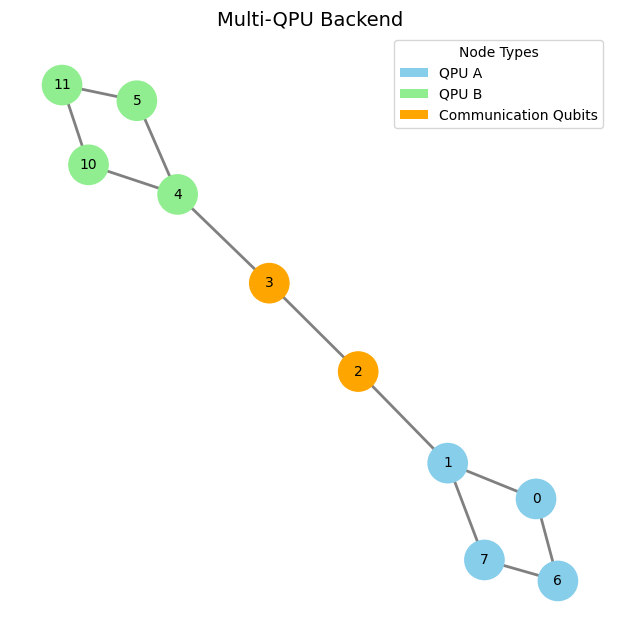

In [13]:
import networkx as nx

graph.clear()

graph.add_nodes_from(active_nodes)
graph.add_edges_from(modified_edges)

node_colors = []
for node in graph.nodes:
    if node in qpu_A:
        node_colors.append("skyblue")    # QPU A
    elif node in qpu_B:
        node_colors.append("lightgreen") # QPU B
    else:
        node_colors.append("orange")     # Communication qubits

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# Use spring layout for a clean look
pos = nx.spring_layout(graph, seed=4)

nx.draw(
    graph,
    pos,
    with_labels=True,
    node_color=node_colors,
    node_size=800,
    font_size=10,
    edge_color="gray",
    width=2
)

from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="skyblue", label="QPU A"),
    Patch(facecolor="lightgreen", label="QPU B"),
    Patch(facecolor="orange", label="Communication Qubits")
]

plt.legend(
    handles=legend_elements,
    loc="upper right",
    fontsize=10,
    title="Node Types"
)

plt.title("Multi-QPU Backend", fontsize=14)
plt.show()


The coupling map clearly shows us that QPU A and B can only communicate through the channel provided by the communication qubits 3 and 2 as required. This is where any teleportation procedure is done, as allocated by DisQCO, and will emulate the action of any non-local gates.

Using Qiskit's ```GenericBackendV2```, we pass our coupling map and now has a runable backend ready to simulate with.

In [14]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import CouplingMap

num_qubits = 12

coupling_map = CouplingMap(modified_edges)
seed = 42

backend = GenericBackendV2(num_qubits=num_qubits, coupling_map=coupling_map, seed=seed, noise_info=True, pulse_channels=True)

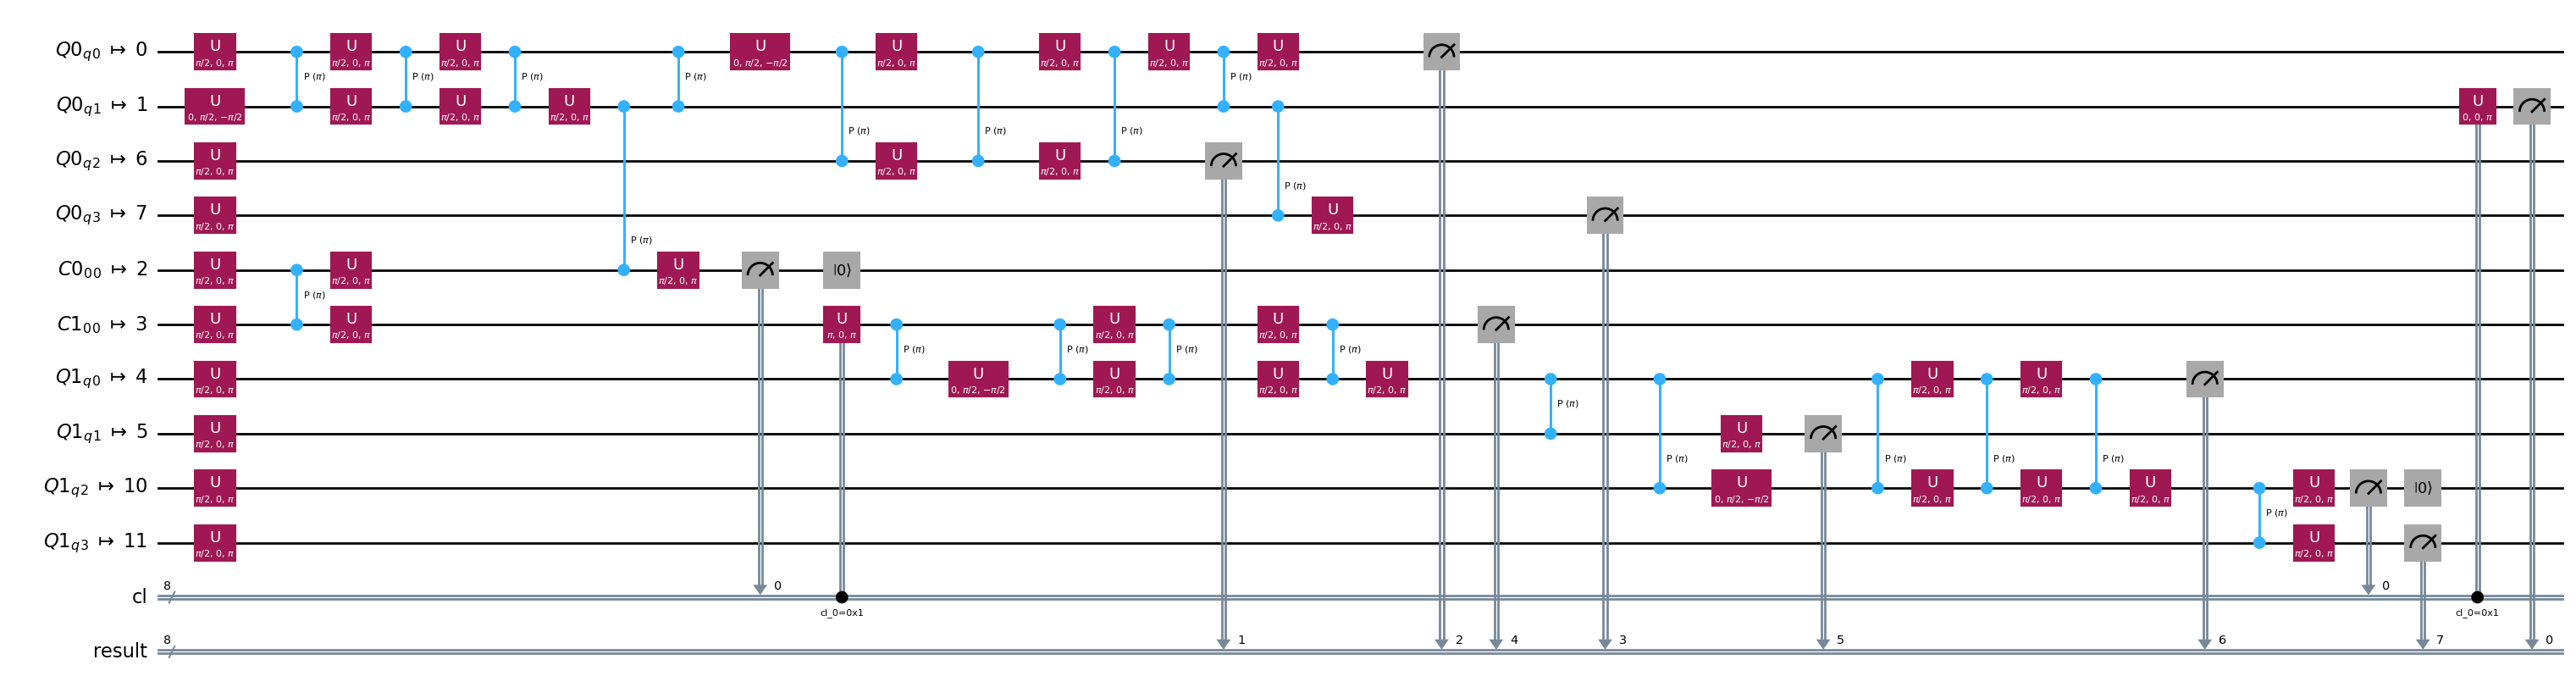

In [15]:
mapped_circ = transpile(partitioned_circuit, backend, initial_layout=qubit_to_qpu_mapping, optimization_level=2, basis_gates=['u', 'cp'])
mapped_circ.draw(output='mpl', fold=50, idle_wires=False, wire_order=[0,1,6,7,2,3,4,5,10,11,8,9,], cregbundle=True, with_layout=True)

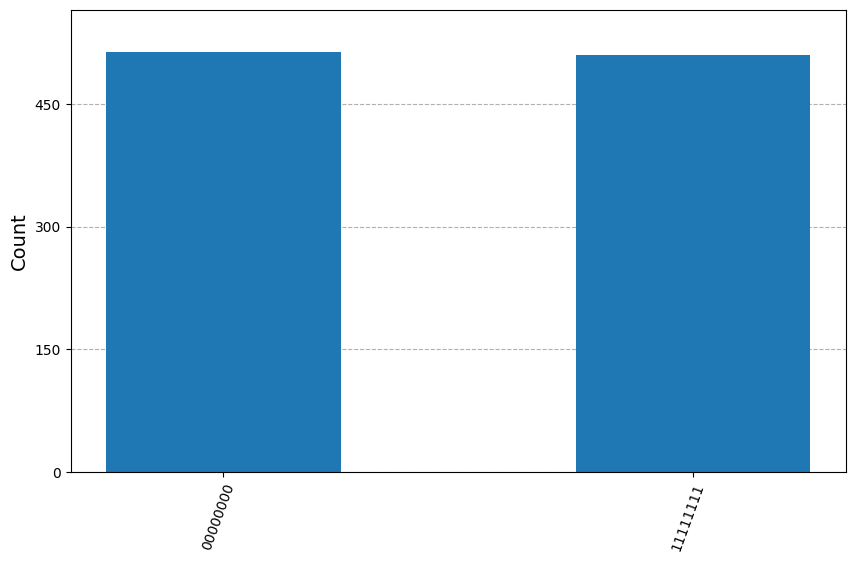

In [16]:
from qiskit_aer.primitives import SamplerV2
from disqco.circuit_extraction.verification import plot

Sampler = SamplerV2()

job = Sampler.run([mapped_circ], shots=1024)
job_result = job.result()
data = job_result[0].data

plot(data, labels=True)

After successfully running a basic 8 qubit GHZ-state preparation circuit on our noiseless virtual backend, we can now move to add specific noise models to improve the realism of our experiment. 

We could approach this in a few ways. One option is to insert random Pauli gates along the communication-qubit wires to simulate noise. Another, more flexible approach is to use Qiskit’s custom noise model framework to introduce operation-specific errors. We’ll take the latter route, comparing how depolarizing and amplitude-damping noise affect feed-forward errors.


In [17]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

# Create a noise model
noise_model = NoiseModel()

# Single-qubit depolarizing error for 'u' gates
error_u = depolarizing_error(0.05, 1)

# Two-qubit depolarizing error for 2-qubit gates (e.g., 'cp')
error_2q = depolarizing_error(0.1, 2)

# Apply single-qubit noise only on qubits 2 and 3
for qubit in [2, 3]:
    noise_model.add_quantum_error(error_u, ["u"], [qubit])

# Get number of qubits from backend (BackendV2-safe)
num_qubits = backend.num_qubits

# Apply two-qubit noise for interactions involving qubit 2 or 3
for q1 in range(num_qubits):
    for q2 in range(num_qubits):
        if q1 != q2 and (q1 in [2, 3] or q2 in [2, 3]):
            noise_model.add_quantum_error(error_2q, ["cp"], [q1, q2])

print(noise_model)

# Attach the noise model to backend for simulation
backend.set_options(noise_model=noise_model)


NoiseModel:
  Basis gates: ['cp', 'cx', 'id', 'rz', 'sx', 'u']
  Instructions with noise: ['cp', 'u']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  Specific qubit errors: [('u', (2,)), ('u', (3,)), ('cp', (0, 2)), ('cp', (0, 3)), ('cp', (1, 2)), ('cp', (1, 3)), ('cp', (2, 0)), ('cp', (2, 1)), ('cp', (2, 3)), ('cp', (2, 4)), ('cp', (2, 5)), ('cp', (2, 6)), ('cp', (2, 7)), ('cp', (2, 8)), ('cp', (2, 9)), ('cp', (2, 10)), ('cp', (2, 11)), ('cp', (3, 0)), ('cp', (3, 1)), ('cp', (3, 2)), ('cp', (3, 4)), ('cp', (3, 5)), ('cp', (3, 6)), ('cp', (3, 7)), ('cp', (3, 8)), ('cp', (3, 9)), ('cp', (3, 10)), ('cp', (3, 11)), ('cp', (4, 2)), ('cp', (4, 3)), ('cp', (5, 2)), ('cp', (5, 3)), ('cp', (6, 2)), ('cp', (6, 3)), ('cp', (7, 2)), ('cp', (7, 3)), ('cp', (8, 2)), ('cp', (8, 3)), ('cp', (9, 2)), ('cp', (9, 3)), ('cp', (10, 2)), ('cp', (10, 3)), ('cp', (11, 2)), ('cp', (11, 3))]


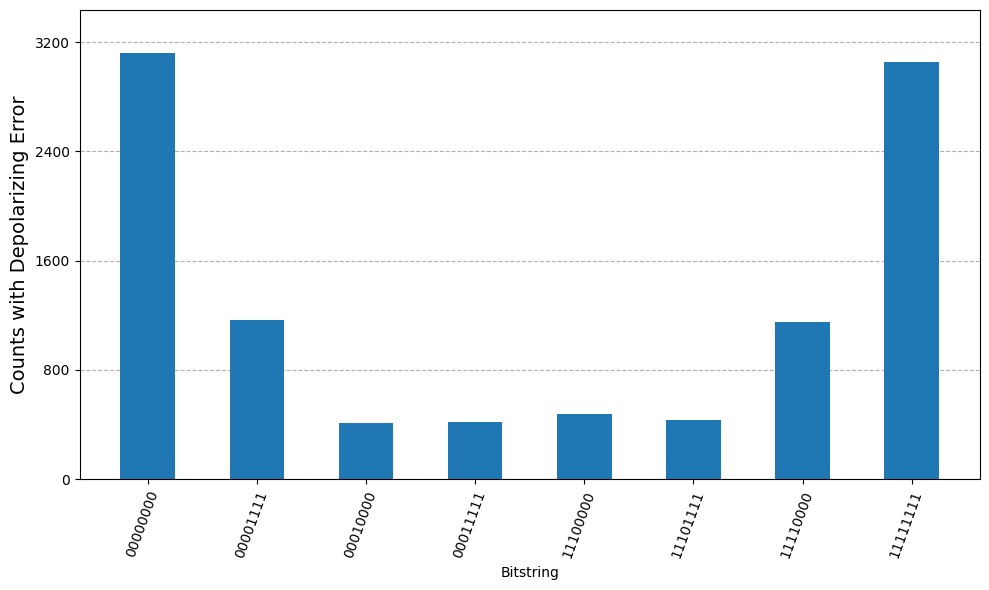

In [18]:
from qiskit_aer.primitives import SamplerV2
from disqco.circuit_extraction.verification import plot
from qiskit_aer import AerSimulator

Sampler_Depolarizing = SamplerV2(options=dict(backend_options=dict(noise_model=noise_model)))

job = Sampler_Depolarizing.run([mapped_circ], shots=10240)
job_result = job.result()
data = job_result[0].data

plot(data, labels=True)
plt.ylabel('Counts with Depolarizing Error')
plt.xlabel('Bitstring')
plt.tight_layout()

Creating a simple depolarizing noise model that acts on operations involving communication qubits only, reflecting the heavy cost associated with using ebits in real life, we've began to smooth the distribution as the sampler picks out more unintended final bitstrings. Interestingly, one can track the fanning out of error due to ebit entangling operations with data qubits, by inspecting the resulting sampled bitstrings. Aside from the GHZ states, states; $\ket{00001111}$, $\ket{00010000}$ and $\ket{00011111}$ are all due to errors propogating on the $\ket{00000000}$ state. Similarly, the last three states are due to errors on the $\ket{11111111}$ state. Refering to the previous partitioned circuit diagram, we can see that there exists only one entangling gate between the ebits and Q0 (QPU A), and 3 between C1 and Q1 (QPU B). Thus, it is far more likely that error on the ebit, will feed-forward through QPU B rather than QPU A. 

In [25]:
from qiskit_aer.noise import NoiseModel, amplitude_damping_error

# Create a noise model
noise_amplitude = NoiseModel()

# Define parameters
gamma_1q = 0.05  # damping probability for single qubit gates
gamma_2q = 0.2  # damping probability for two-qubit gates

# Number of qubits in the backend
num_qubits = backend.num_qubits

# Create single-qubit amplitude damping error
error_1q = amplitude_damping_error(gamma_1q)

# Create two-qubit amplitude damping error
error_2q = amplitude_damping_error(gamma_2q).expand(amplitude_damping_error(gamma_2q))

# Apply noise to single-qubit 'u' gates on qubits 2 and 3
for qubit in [2, 3]:
    noise_amplitude.add_quantum_error(error_1q, ["u"], [qubit])

# Apply noise to two-qubit 'cp' gates involving qubits 2 or 3
for q1 in range(num_qubits):
    for q2 in range(num_qubits):
        if q1 != q2 and (q1 in [2, 3] or q2 in [2, 3]):
            noise_amplitude.add_quantum_error(error_2q, ["cp"], [q1, q2])

print(noise_amplitude)

backend.set_options(noise_model=noise_model)


NoiseModel:
  Basis gates: ['cp', 'cx', 'id', 'rz', 'sx', 'u']
  Instructions with noise: ['cp', 'u']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  Specific qubit errors: [('u', (2,)), ('u', (3,)), ('cp', (0, 2)), ('cp', (0, 3)), ('cp', (1, 2)), ('cp', (1, 3)), ('cp', (2, 0)), ('cp', (2, 1)), ('cp', (2, 3)), ('cp', (2, 4)), ('cp', (2, 5)), ('cp', (2, 6)), ('cp', (2, 7)), ('cp', (2, 8)), ('cp', (2, 9)), ('cp', (2, 10)), ('cp', (2, 11)), ('cp', (3, 0)), ('cp', (3, 1)), ('cp', (3, 2)), ('cp', (3, 4)), ('cp', (3, 5)), ('cp', (3, 6)), ('cp', (3, 7)), ('cp', (3, 8)), ('cp', (3, 9)), ('cp', (3, 10)), ('cp', (3, 11)), ('cp', (4, 2)), ('cp', (4, 3)), ('cp', (5, 2)), ('cp', (5, 3)), ('cp', (6, 2)), ('cp', (6, 3)), ('cp', (7, 2)), ('cp', (7, 3)), ('cp', (8, 2)), ('cp', (8, 3)), ('cp', (9, 2)), ('cp', (9, 3)), ('cp', (10, 2)), ('cp', (10, 3)), ('cp', (11, 2)), ('cp', (11, 3))]


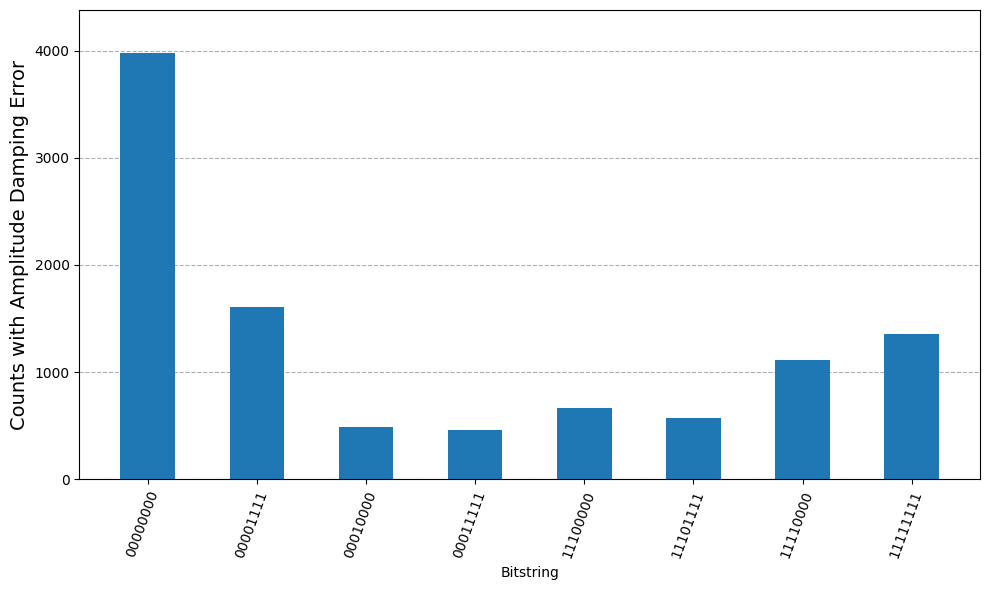

In [26]:
from qiskit_aer.primitives import SamplerV2
from disqco.circuit_extraction.verification import plot
from qiskit_aer import AerSimulator

Sampler_Damped  = SamplerV2(options=dict(backend_options=dict(noise_model=noise_amplitude)))

job = Sampler_Damped.run([mapped_circ], shots=10240)
job_result = job.result()
data = job_result[0].data

plot(data, labels=True)

plt.ylabel('Counts with Amplitude Damping Error')
plt.xlabel('Bitstring')
plt.tight_layout()
plt.savefig("bac04x2_amplitude_damping.png", dpi=300)


Amplitude damping is a dispersive action, and is the decay of excited states to ground. We can see that damping operations involving the ebit, the statevector is driven to its ground, $\ket{00000000}$ as expected.

To take this even further, we can think about the effect measurement errors might have, especially considering their crucial role in the teleportation protocol.

In [28]:
from qiskit.providers.fake_provider import Fake27QPulseV1
from qiskit_aer.noise import NoiseModel, ReadoutError

backend_fake = Fake27QPulseV1()

noise_readout = NoiseModel()

errors = []
for qubit in [2, 3]:
    p_error = backend_fake.properties().readout_error(qubit) # Extracting the error rate of measuring 1 or 0 from an existing qiskit backend
    confusion_matrix = [
        [1 - p_error, p_error],
        [p_error, 1 - p_error]
    ]
    noise_readout.add_readout_error(ReadoutError(confusion_matrix), [qubit])
    
print(noise_readout)
backend.set_options(noise_model=noise_readout)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['measure']
  Qubits with noise: [2, 3]
  Specific qubit errors: [('measure', (2,)), ('measure', (3,))]


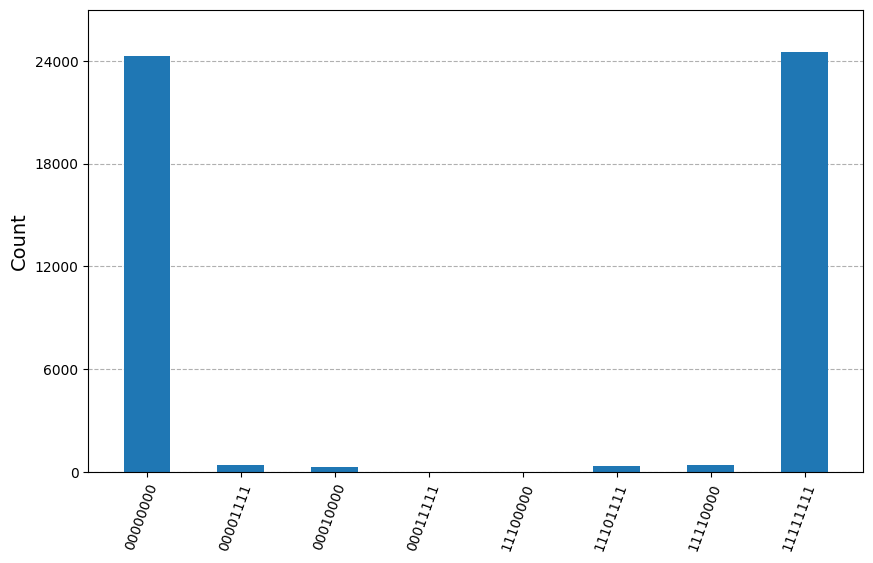

In [29]:
from qiskit_aer.primitives import SamplerV2
from disqco.circuit_extraction.verification import plot
from qiskit_aer import AerSimulator

Sampler_readout  = SamplerV2(options=dict(backend_options=dict(noise_model=noise_readout)))

job = Sampler_readout.run([mapped_circ], shots=50240) # Increase shots, since the effect of the noise is small
job_result = job.result()
data = job_result[0].data

plot(data, labels=True)

Whilst only leading to an erroneous state a neglible percent of the time, for a circuit with greater cross QPU entangling operations, such as QFT, this error channel would likely have a greater impact on end-state fidelities.

Common in each plot are the final bitstring possibilites. We see that from a total of 2<sup>8</sup> possible states, even with strong depolarizing error rates, only 2<sup>3</sup> are sampled. With 2 of those being the intended GHZ states, the remaining 6 states are erroneous and come about due to our addition of noise.

Further works might include experimentation on real hardware, more savvy use of ebits (using ancilla qubits to hold entanglement) and testing with more complex circuits such as VQA - which are naturally distributable.